# 层和快
为了实现复杂的网络，引入了神经网络块的概念。块（block）可以描述单个层、由多个层组成的组件或整个模型本身。使用块进行抽象的好处是可以将一些块组合成更大的组件，这一过程通常是递归的，如图所示

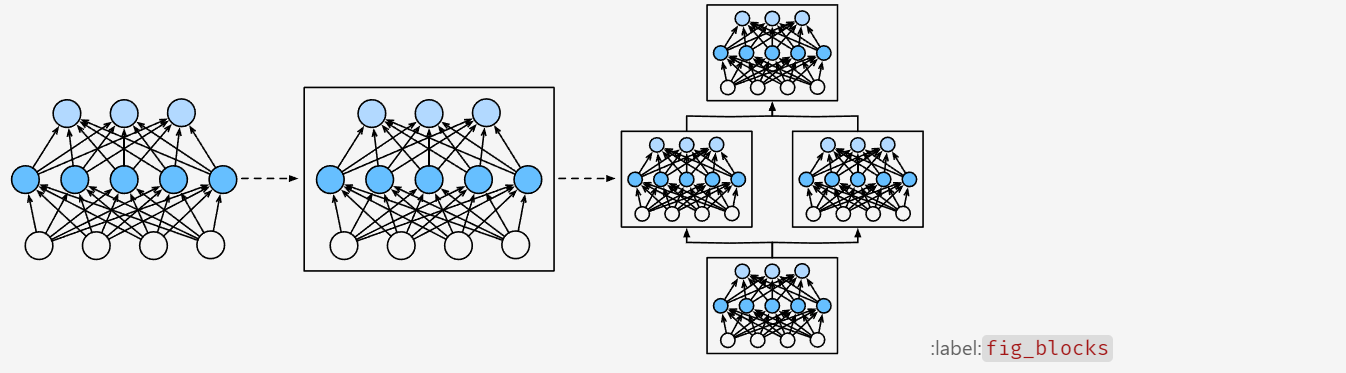

块由类表示，它的任何子类都必须定义一个将其输入转换为输出的前向传播函数并且必须任何必须的参数。注意，有些块不需要任何的参数。最后，为了计算梯度，块必须具有反向传播函数，在定义我们自己的块时，由于自动微分提供了一些后端实现，我们只需要考虑前向传播函数和必须的参数。

在构造自定义块之前，先回顾一下多层感知机的代码。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F

net = nn.Sequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))

X = torch.rand(2, 20)
net(X)

tensor([[-3.9048e-05, -7.3932e-02,  5.5151e-02,  1.3319e-01, -2.2024e-01,
          1.5352e-01,  2.0753e-01, -6.9286e-02, -3.9024e-02, -9.8397e-02],
        [ 1.5385e-01, -1.3635e-02,  1.6167e-01,  1.5353e-01, -2.0713e-01,
          6.5280e-02,  1.0229e-01,  2.8670e-02,  9.7672e-02, -1.3570e-01]],
       grad_fn=<AddmmBackward0>)

其中包含256个单元和ReLU激活函数的全连接隐藏层，然后是一个具有10个隐藏单元且不带激活函数的全连接输出层。

## 自定义块
每个块必须提供的基础功能

1. 将输入数据作为其前向传播函数的参数。
1. 通过前向传播函数来生成输出，请注意输出的形状可能与输入的形状不同。例如，我们在上面的模型中的第一个全链接的层接受一个20维的输入，但是返回一个维度为256的输出。
1. 计算其输出关于输入的梯度，可以通过其反向传播函数进行访问，通常这是自动发生的。
1. 存储和访问前向传播计算所需的参数。
1. 根据需要初始化模型参数。

注意下面的`MLP`类继承了表示块的类。我们的实现只需要提供我们自己的构造函数和前向传播函数。

In [2]:
class MLP(nn.Module):
    # 用模型参数声明层。这里，我们声明两个全连接的层
    def __init__(self):
        # 调用MLP的父类Module的构造函数来执行必要的初始化。
        # 这样，在类实例化时也可以指定其他函数参数，例如模型参数params
        super().__init__()
        self.hidden = nn.Linear(20, 256)
        self.out = nn.Linear(256, 10)

    # 定义模型的前向传播，即如何根据输入X返回所需的模型输出
    def forward(self, X):
        # 这里使用ReLU函数，其在nn.functional模块中定义。
        return self.out(F.relu(self.hidden(X)))


先来看一下前向传播函数，以`X`作为输出，计算带有激活函数的隐藏表示，并输出其未规范化的输出值。在这个`MLP`实现中，两层都是实例变量。要了解为什么是合理的，可以想象实例化两个多层感知机，并根据不同的数据进行训练。我们希望他能学习两种不同的模型。

接着`实例化多层感知机的层，然后在每次调用前向传播函数时调用这些层`。

首先定制的`__init__`函数通过`super().__init__()`调用父类的`__init__`函数，省去了重现编写模板代码的痛苦。然后，实例化了两个全连接层，分别为`self.hidden`和`self.out`。注意，除非实现新的运算符，否则我们不必担心反向传播函数或参数初始化，系统将自动生成这些。

试一下以下函数：

In [3]:
net = MLP()
net(X)

tensor([[-0.2080,  0.1138,  0.0795,  0.4915,  0.0953,  0.0024, -0.0513, -0.0165,
          0.0691, -0.1888],
        [-0.3568,  0.1266,  0.0099,  0.3343,  0.0233, -0.0635, -0.0206,  0.0437,
          0.1496, -0.2527]], grad_fn=<AddmmBackward0>)

块的一个主要优点就是它的多功能性。我们可以子类化块以创建层（如全连接层的类）、整个模型(如上面的`MLP`类)或具有中等复杂度的各种组件。

# 顺序块
现在我们可以更仔细地看看`Sequential`类是如何如何工作的，回想一下`Sequential`的设计是为了把其他的模块串起来。为了构建简化的`MySequential`，只需要定义两个关键函数：

1. 一种将块逐个追加到列表中的函数；
1. 一种前向传播函数，用于将输入按追加块的顺序传递给块组成的“链条”。

In [4]:
class MySequential(nn.Module):
    def __init__(self, *args):
        super().__init__()
        for idx, module in enumerate(args):
            # 这里, module是Module子类的一个实例。我们把它保存在'Module'类的成员
            # 变量_module中。_module的类型是OrderedDict
            self._modules[str(idx)] = module

    def forward(self, X):
        # OrderedDict保证了按照成员添加的顺序遍历他们
        for block in self._modules.values():
            X = block(X)
        return X

使用`MySequential`类重新实现多层感知机

In [5]:
net = MySequential(nn.Linear(20, 256), nn.ReLU(), nn.Linear(256, 10))
net(X)

tensor([[-0.2290, -0.0596,  0.1382,  0.0261,  0.0846, -0.2053,  0.2879, -0.2882,
          0.1327,  0.0111],
        [-0.2247, -0.0953,  0.0252, -0.0402,  0.1648, -0.0978,  0.2035, -0.1439,
         -0.0158, -0.0255]], grad_fn=<AddmmBackward0>)

# 在前向传播函数中执行代码


In [8]:
class FixedHiddenMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # 不计算梯度的随机权重参数。因此在训练期间保持不变
        self.rand_weight = torch.rand((20, 20), requires_grad=False)
        self.linear = nn.Linear(20, 20)

    def forward(self, X):
        X = self.linear(X)
        # 使用创建的常量参数以及relu和mm函数
        X = F.relu(torch.mm(X, self.rand_weight) + 1)
        # 复用全连接层。这相当于两个全连接层共享参数
        X = self.linear(X)
        # 控制流
        while X.abs().sum() > 1:
            X /= 2
        return X.sum()


在上述模型中，我们实现了一个隐藏层，其权重在实例化时被初始化，之后为常量。这个权重不是模型参数，因此永远不会被反向传播更新。然后，神经网络将这个固定层的输出通过一个全连接层。

注意在返回输出之前，模型做了一些不寻常的事情：它运行了一个while循环，在 $L_1$ 范数大于1的条件下，将输出向量除以2，知道它满足条件为止。最后，模型返回了`X`中所有项的和。

In [9]:
net = FixedHiddenMLP()
net(X)

tensor(0.0088, grad_fn=<SumBackward0>)

可以`混合搭配各种组合块`的方法

In [11]:
class NestMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(20, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU())
        self.linear = nn.Linear(32, 16)
    
    def forward(self, X):
        return self.linear(self.net(X))
    
chimera = nn.Sequential(NestMLP(), nn.Linear(16, 20), FixedHiddenMLP())
chimera(X)

tensor(0.0595, grad_fn=<SumBackward0>)